<a href="https://colab.research.google.com/github/jfrchicanog/quantuma-course/blob/main/QAOA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We first install the qiskit and some utility packages.

In [ ]:
!pip install qiskit qiskit-aer matplotlib pylatexenc networkx scipy

We import the required libraries.

In [ ]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from networkx import Graph, draw
from scipy.optimize import minimize

This function builds the circuit from the graph and a vector with parameters γ y β

In [ ]:
def get_circuit(G, theta):
  nqubits = len(G.nodes())
  circuit = QuantumCircuit(nqubits)
  p = len(theta)//2

  gamma = theta[:p]
  beta = theta[p:]

  # We prepare the superposition of all the basis states with Hadamard gates
  for i in range(0, nqubits):
    circuit.h(i)

  # Repeat p times the problem-dependent and mixer circuits
  for i in range(0,p):
    # Problem-dependent circuit
    for l,k in G.edges():
      circuit.rzz(2 * gamma[i],l,k)

    # Mixer circuit
    for qbit in range(0,nqubits):
      circuit.rx(2 * beta[i], qbit)

  # Measure all qubits to sample a solution
  circuit.measure_all()

  return circuit

We prepare a runtime environment (simulated in this case) and we prepare a function to run the circuit in that environment. This function will later be useful to get the results once the classic algorithm has optimized the parameters of the circuit.

In [ ]:
env = Aer.get_backend('qasm_simulator')

def run_circuit(G, theta, shots=1000):
    circuit = get_circuit(G, theta)
    histogram = env.run(circuit, nshots=shots).result().get_counts()
    return histogram

The objective function must run the quantum circuit several times and compute the average value of the objective function for the solutions sampled in different runs. We present the objective function next. The input parameters are a vector with the decision variables (angles γ and β) and the number of samples to use for the quantum circuit.

In [ ]:
def objective_function(G, shots=1000):

  def count_crossing_edges(solution):
    crossing_edges = 0
    for i,j in G.edges():
      if solution[i] != solution[j]:
        crossing_edges += 1
    return crossing_edges

  def run_average_computation(theta):
    histogram = run_circuit(G, theta, shots)

    sum = 0
    runs = 0
    for solucion, times in histogram.items():
      # The solution is inverted (the most significant bit first)
      crossing_edges = count_crossing_edges(solution[::-1])
      sum += crossing_edges * times
      runs += times

    return -sum/runs

  return run_average_computation


We use a classic optimization algorithm to solve the problem. We use COBYLA in SciPy.

In [ ]:
def optimize(G):
  objective = objective_function(G)
  return minimize(objective,[1.0,1.0,1.0,1.0], method='COBYLA')


Let's try the algorithm in a graph with 5 vertices and 6 edges.

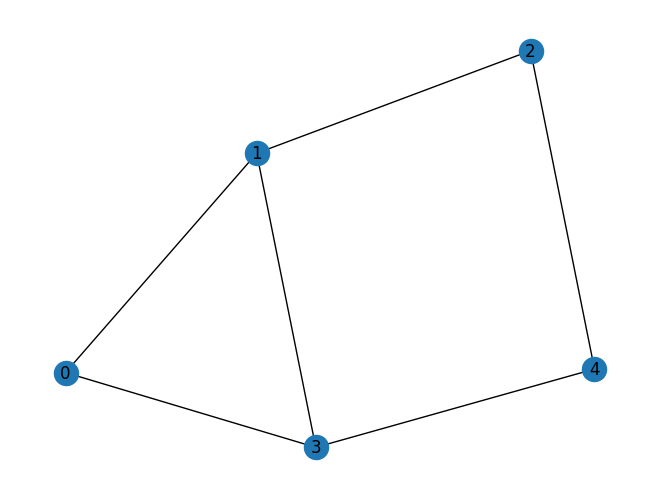

In [ ]:
G = Graph()
G.add_nodes_from([0,1,2,3,4])
G.add_edges_from([(0,1),(0,3),(1,3),(1,2),(2,4),(3,4)])
draw(G, with_labels=True)

We apply QAOA to find the optimal parameters for the circuit.

In [ ]:
result = optimize(G)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.9658203125
       x: [ 8.391e-01  1.866e+00  1.431e+00  1.883e+00]
    nfev: 46
   maxcv: 0.0

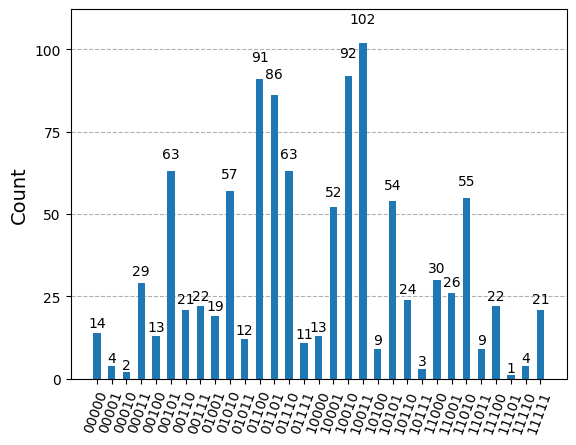

In [ ]:
histogram = run_circuit(G, result.x)
plot_histogram(histogram)